In [26]:
%pip install sentence-transformers scikit-learn pandas --quiet

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Note: you may need to restart the kernel to use updated packages.


In [27]:
sample_queries = [
    "On beş yaşındaki biriyle rızaya dayalı ilişki yasal mıdır?",
    "Çocuğun uygunsuz şekilde fotoğrafını çekmek suç sayılır mı?",
    "Reşit olmayan biriyle cinsel ilişkiye girmenin cezası nedir?",
    "OHAL ilan edildikten sonra hangi haklar askıya alınabilir?",
    "Cinsel istismara uğramış bir çocuğun görüntüsünü paylaşmak hangi suça girer?",
    "Akıl hastası bir bireyin evliliği geçerli midir?",
    "Boşanma sırasında taraflardan biri ayırt etme gücüne sahip değilse ne olur?",
    "Kamu yararı gerekçesiyle özel mülkiyete el konulabilir mi?",
    "Sendika grev çağrısı yaptıktan sonra devlet bu grevi engelleyebilir mi?",
    "Cinsel içerikli görüntü paylaşımı TCK'ya göre nasıl cezalandırılır?"
]

In [28]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from dotenv import load_dotenv
from pinecone import Pinecone
from sentence_transformers import SentenceTransformer


🔎 Question: On beş yaşındaki biriyle rızaya dayalı ilişki yasal mıdır?
Top-3 match scores: []
  → Threshold 0.6: 0 match(es) ≥ threshold
  → Threshold 0.65: 0 match(es) ≥ threshold
  → Threshold 0.7: 0 match(es) ≥ threshold
  → Threshold 0.75: 0 match(es) ≥ threshold
  → Threshold 0.8: 0 match(es) ≥ threshold
  → Threshold 0.85: 0 match(es) ≥ threshold
  → Threshold 0.9: 0 match(es) ≥ threshold

🔎 Question: Çocuğun uygunsuz şekilde fotoğrafını çekmek suç sayılır mı?
Top-3 match scores: []
  → Threshold 0.6: 0 match(es) ≥ threshold
  → Threshold 0.65: 0 match(es) ≥ threshold
  → Threshold 0.7: 0 match(es) ≥ threshold
  → Threshold 0.75: 0 match(es) ≥ threshold
  → Threshold 0.8: 0 match(es) ≥ threshold
  → Threshold 0.85: 0 match(es) ≥ threshold
  → Threshold 0.9: 0 match(es) ≥ threshold

🔎 Question: Reşit olmayan biriyle cinsel ilişkiye girmenin cezası nedir?
Top-3 match scores: []
  → Threshold 0.6: 0 match(es) ≥ threshold
  → Threshold 0.65: 0 match(es) ≥ threshold
  → Threshold 0.7

/opt/homebrew/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


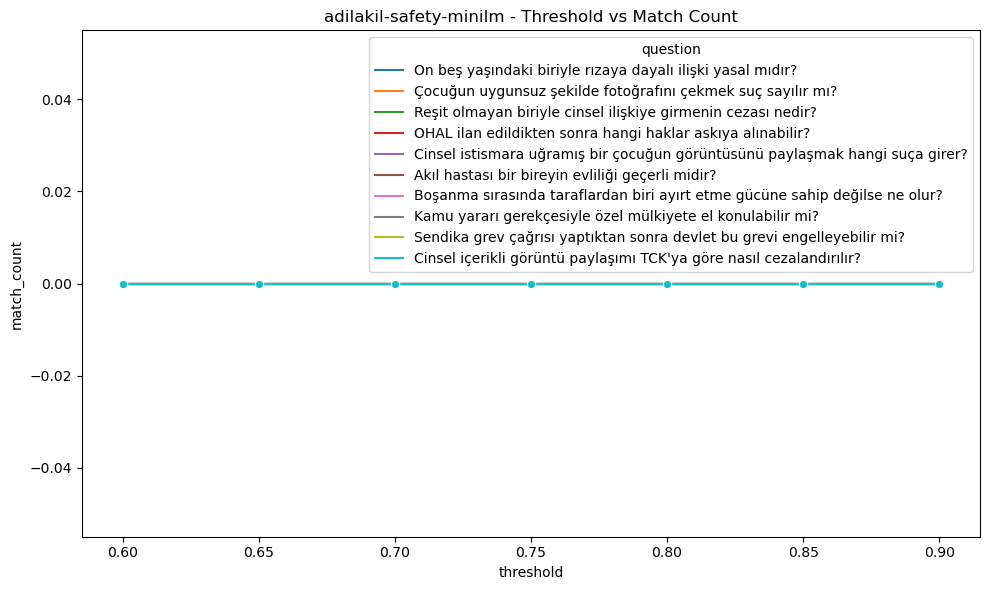

In [29]:
# === Config ===
load_dotenv()
PINECONE_API_KEY = os.getenv("PINECONE_API_KEY")
INDEX_NAME = "adilakil-safety-minilm"
NAMESPACE = "default"
TOP_K = 3
THRESHOLDS = [0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9]

# === Init ===
pc = Pinecone(api_key=PINECONE_API_KEY)
index = pc.Index(INDEX_NAME)
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

# === Sonuçları topla
records = []

for question in sample_queries:
    vec = embedding_model.encode(question).tolist()
    result = index.query(
        vector=vec,
        top_k=TOP_K,
        include_metadata=True,
        namespace=NAMESPACE
    )

    print(f"\n🔎 Question: {question}")
    print(f"Top-{TOP_K} match scores: {[round(m.score, 4) for m in result.matches]}")

    for threshold in THRESHOLDS:
        filtered = [m for m in result.matches if m.score >= threshold]
        count = len(filtered)
        max_score = round(max([m.score for m in result.matches]), 4) if result.matches else 0.0

        print(f"  → Threshold {threshold}: {count} match(es) ≥ threshold")

        records.append({
            "index_name": INDEX_NAME,
            "question": question,
            "threshold": threshold,
            "match_count": count,
            "top_score": max_score
        })

# === DataFrame ve pivot
df = pd.DataFrame(records)
pivot_df = df.pivot(index="threshold", columns="question", values="match_count")

# === Görselleştirme (isteğe bağlı)
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x="threshold", y="match_count", hue="question", marker="o")
plt.title(f"{INDEX_NAME} - Threshold vs Match Count")
plt.xticks(THRESHOLDS)
plt.tight_layout()
plt.show()